In [1]:
import os
from typing import List, Union, Generator, Iterator
from pydantic import BaseModel
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.ollama import Ollama
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader
import pandas as pd


In [2]:
class RAG:

    class Parameters(BaseModel):
        LLAMAINDEX_OLLAMA_BASE_URL: str
        LLAMAINDEX_MODEL_NAME: str
        LLAMAINDEX_EMBEDDING_MODEL_NAME: str

    def __init__(self):
        self.documents = None
        self.index = None

        self.parameters = self.Parameters(
            LLAMAINDEX_OLLAMA_BASE_URL=os.getenv("LLAMAINDEX_OLLAMA_BASE_URL", "http://localhost:11434"),
            LLAMAINDEX_MODEL_NAME=os.getenv("LLAMAINDEX_MODEL_NAME", "llama3.2:3b"),
            LLAMAINDEX_EMBEDDING_MODEL_NAME=os.getenv("LLAMAINDEX_EMBEDDING_MODEL_NAME", "jina/jina-embeddings-v2-base-en:latest"),
        )

    def on_startup(self):
        Settings.embed_model = OllamaEmbedding(
            model_name=self.parameters.LLAMAINDEX_EMBEDDING_MODEL_NAME,
            base_url=self.parameters.LLAMAINDEX_OLLAMA_BASE_URL,
        )
        Settings.llm = Ollama(
            model=self.parameters.LLAMAINDEX_MODEL_NAME,
            base_url=self.parameters.LLAMAINDEX_OLLAMA_BASE_URL,
        )

        self.documents = SimpleDirectoryReader("test/dataset").load_data()
        self.index = VectorStoreIndex.from_documents(self.documents)

    def on_shutdown(self):
        pass

    def pipe(
        self, user_message: str, model_id: str, messages: List[dict], body: dict
    ) -> Union[str, Generator, Iterator]:
        query_engine = self.index.as_query_engine(streaming=True)
        response = query_engine.query(user_message)
        return response.response_gen


def run_query_sync(query: str) -> str:
    rag = RAG()
    rag.on_startup()

    user_message = query
    model_id = "llama3.2:3b"
    messages = [{"role": "user", "content": user_message}]
    body = {}

    response_gen = rag.pipe(user_message, model_id, messages, body)
    response_text = ''.join(response_gen)

    rag.on_shutdown()
    return response_text



In [16]:

def get_billable_answer(long_answer):
    # Split the string by lines
    lines = long_answer.split('\n')
    # Find the line that starts with 'answer:'
    for line in lines:
        if line.startswith("answer:"):
            answer = line.split(":")[1].strip()
            break
    return answer


In [17]:

def get_context_answer(long_answer):
    # Split the string by lines
    lines = long_answer.split('\n')
    # Find the line that starts with 'answer:'
    for line in lines:
        if line.startswith("context:"):
            answer = line.split(":")[1].strip()
            break
    return answer


In [20]:

if __name__ == "__main__":

    prompt_old = 'Classify this question if the request is under the Service Level Agreement (SLA) or not. Return both the relevant passage in the SLA and if the request is covered or not (yes / no)'
    prompt = f"""Classify if the following request is under the Service Level Agreement (SLA) or not. Return your reply in the following format:
            answer: [Billable / Not Billable]
            context: [relevant passage from the SLA]
            """

    
    df_questions = pd.read_csv('test/qa/QA_billability.csv')
    df_questions['predicted_answer'] = None
    df_questions['predicted_answer'] = None
    #print('questions')
    #print(questions)

    df_questions.head(5)

    #for case_nb in range(0,3):
    for case_nb in range(0,df_questions.shape[0]):
        #question = "Subject: IMBL Scanner Breakdown - Immediate Repair Required Dear Support Team, We are experiencing a sudden breakdown of our IMBL Scanner, rendering it non-operational. We request immediate assistance for emergency repairs to restore functionality as soon as possible. Thank you for your prompt attention to this matter. Best regards, [Customer Name]"
        question = df_questions['question'][case_nb]
        query = prompt + question
        print("\n================================")
        print(f'case_nb', case_nb)     
        print(question)
        #print(query)
        response = run_query_sync(query)
        print("\nResponse:")
        print(response)
        pred_billable = get_billable_answer(response)
        df_questions.loc[case_nb, 'predicted_answer'] = pred_billable

        pred_context = get_context_answer(response)
        df_questions.loc[case_nb, 'predicted_context'] = pred_context
        print(f'expected_answer:', df_questions['expected_answer'][case_nb])
        print(f'expected_context:', df_questions['context'][case_nb])
        print("\n--------------------------------")





case_nb 0
Subject: IMBL Scanner Breakdown - Immediate Repair Required Dear Support Team, We are experiencing a sudden breakdown of our IMBL Scanner, rendering it non-operational. We request immediate assistance for emergency repairs to restore functionality as soon as possible. Thank you for your prompt attention to this matter. Best regards, [Customer Name]

Response:
answer: Not Billable
context: 19.2. Response Times - Emergency Maintenance: For critical issues that render the Equipment non-operational, the Service Provider shall respond within 2 hours of notification and commence repairs within 4 hours.
Subject: IMBL Scanner Breakdown - Immediate Repair Required Dear Support Team, We are experiencing a sudden breakdown of our IMBL Scanner, rendering it non-operational. We request immediate assistance for emergency repairs to restore functionality as soon as possible. Thank you for your prompt attention to this matter. Best regards, [Customer Name]
expected_answer: Billable
expected

In [21]:
df_questions

,question,expected_answer,context,predicted_answer,predicted_context
0,Subject: IMBL Scanner Breakdown - Immediate Re...,Billable,Emergency maintenance is typically covered but...,Not Billable,19.2. Response Times - Emergency Maintenance
1,Subject: Scheduled Maintenance Request for IMB...,Not Billable,Routine maintenance is usually included in the...,Not Billable,19.7. Exclusions - Scheduled Maintenance
2,Subject: Request for Software Upgrade on IMBL ...,Billable,Routine maintenance is usually included in the...,Not Billable,19.5. Reporting
3,Subject: Request for Additional IMBL Scanner T...,Billable,Upgrades are generally outside the regular mai...,Not Billable,19.4. Performance Standards - Qualified Personnel
4,Subject: Request for Replacement of Defective ...,Not Billable,Training services are not part of regular main...,Not Billable,19.4. Performance Standards - Qualified Personnel
5,Subject: Request for Customization of IMBL Sca...,Billable,Replacement under warranty is typically covere...,Not Billable,
6,Subject: Request for Detailed Monthly Performa...,Billable,Customization generally falls outside standard...,Not Billable,19.5 Reporting
7,Subject: Repair Request for IMBL Scanner - Acc...,Billable,If detailed reports are part of the agreed SLA...,Not Billable,19.2. Response Times - For non-critical issues...
8,Subject: Request for Installation and Setup of...,Billable,User-caused damage is typically not covered un...,Not Billable,19.1. Availability - Downtime Calculation
9,Subject: Request for Remote Troubleshooting - ...,Not Billable,This would be considered a new project setup a...,Not Billable,19.2. Response Times


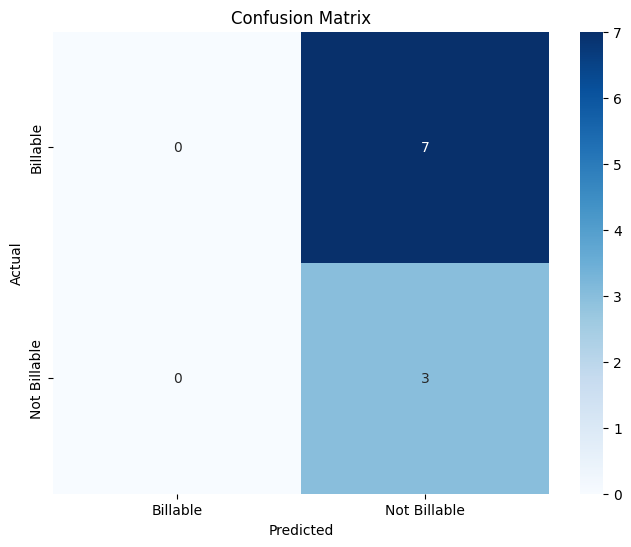

In [24]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Create confusion matrix
conf_matrix = confusion_matrix(df_questions['expected_answer'], df_questions['predicted_answer'], labels=['Billable', 'Not Billable'])

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Billable', 'Not Billable'], columns=['Billable', 'Not Billable'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
df_questions